In [1]:
# Скачивание данных

from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')
files.upload()

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"egorkeen2","key":"93fa279ba640a1df760d59dbdb9b50aa"}'}

In [2]:
!ls -lha kaggle.json

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d whenamancodes/predict-diabities
!unzip predict-diabities.zip

-rw-r--r-- 1 root root 65 Dec 18 21:55 kaggle.json
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 17.3MB/s]
Archive:  predict-diabities.zip
  inflating: diabetes.csv            


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Установка catboost

!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import (
    f1_score, average_precision_score, # метрики для задачи классификации
    mean_squared_error, mean_absolute_error, r2_score, # метрики для задачи регрессии
)
from sklearn.preprocessing import OrdinalEncoder

# Модели
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
)
from xgboost import (
    XGBClassifier,
    XGBRegressor,
)
from lightgbm import (
    LGBMClassifier,
    LGBMRegressor,
)
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor,
)

In [6]:
# Установка размеров шрифтов для графиков
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=16)          # размеры текста по умолчанию
plt.rc('axes', titlesize=20)     # размер шрифта заголовка осей
plt.rc('axes', labelsize=18)     # размер шрифта названия осей
plt.rc('xtick', labelsize=18)    # размер шрифта меток по оси x
plt.rc('ytick', labelsize=18)    # размер шрифта меток по оси y
plt.rc('legend', fontsize=16)    # размер шрифта легенды
plt.rc('figure', titlesize=20)   # размер шрифта заголовка всего графика

In [7]:
# Чтение, анализ и предобработка данных

df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
target = df["Outcome"]

df = df.drop("Outcome", axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [10]:
# Проверка всех колонок на численность

numerical_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
len(numerical_cols) == df.shape[1]

True

In [11]:
# Деление выборки на обучающую и тестовую

X_train, X_test, y_train, y_test = train_test_split(
    df,
    target,
    test_size=0.33,
    random_state=42,
    stratify=target, # поделим выборку таким образом, чтобы и в обучающей, и в тестовой выборке было такое же соотношение классов, как и в исходных данных
)

In [12]:
# баланс классов

val_count_init = pd.Series(target).value_counts().to_dict()
val_count_train = y_train.value_counts().to_dict()
val_count_test = y_test.value_counts().to_dict()

get_relation = lambda x: round(x[1] / x[0], 2)

print(
    """
    Соотношение классов в исходной выборке:  {}\t(класс 1 / класс 0 = {})
    Соотношение классов в обучающей выборке: {}\t(класс 1 / класс 0 = {})
    Соотношение классов в тестовой выборке:  {}\t(класс 1 / класс 0 = {})
    """.format(
        val_count_init, get_relation(val_count_init),
        val_count_train, get_relation(val_count_train),
        val_count_test, get_relation(val_count_test),
    )
)


    Соотношение классов в исходной выборке:  {0: 500, 1: 268}	(класс 1 / класс 0 = 0.54)
    Соотношение классов в обучающей выборке: {0: 335, 1: 179}	(класс 1 / класс 0 = 0.53)
    Соотношение классов в тестовой выборке:  {0: 165, 1: 89}	(класс 1 / класс 0 = 0.54)
    


In [13]:
# Функция для подбора гиперпараметров для моделей

def gridsearch(X_train, y_train, model, params, scoring, cv):
  """Перебор всевозможных гиперпараметров.

  :param X_train: объекты обучающей выборки
  :param y_train: значения целевой переменной обучающей выборки
  :param model: модель, для которой производится подбор гиперпараметров
  :param params: словарь с названиями гиперпараметрамов и всеми наборами значений
  :param scoring: функция, которая будет минимизироваться в ходе кросс-валидации (можно передать список метрик)
  :param cv: количество частей, на которые будет поделена выборка

  :return: наилучшие гиперпараметры
  """
  searcher = GridSearchCV(
      estimator=model,
      param_grid=params,
      scoring=scoring,
      cv=cv,
      verbose=0, # чтобы выводилось что-то в процессе подбора параметров, необходимо выставить какое-то значение > 0
  )
  searcher.fit(X_train, y_train)
  best_params = searcher.best_params_

  # print("Best hyperparameters:", best_params)
  return best_params

In [14]:
# Функция для обучения и тестирования модели

def model_train_test(X_train, y_train, X_test, y_test, model, model_type):
    """Обучение и тестирование модели на обучающей и тестовой выборке соответственно.

    :param X_train: объекты обучающей выборки
    :param y_train: значения целевой переменной обучающей выборки
    :param X_test: объекты тестовой выборки
    :param y_test: значения целевой переменной тестовой выборки
    :param model: модель, которая обучается и тестируется
    :param model_type: тип модели: 'classification' или 'regression'
    :return: предсказания и метрики
    """
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    if model_type == "regression":
        mse = mean_squared_error(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        print("MSE = {}; MAE = {}; R2 = {}".format(round(mse, 3), round(mae, 3),round(r2, 3)))
        return pred, (mse, mae, r2)
    elif model_type == "classification":
        f1 = f1_score(y_test, pred)
        proba = model.predict_proba(X_test)[:, 1]
        pr_auc = average_precision_score(y_test, proba)
        print("F1 = {}; PR AUC = {}".format(round(f1, 3), round(pr_auc, 3)))
        return (pred, proba), (f1, pr_auc)
    else:
        raise Exception("Тип модели model_type должен быть 'classification' или 'regression'.")

In [15]:
def find_and_train_test_best_params(
    X_train, y_train,
    params, scoring, cv,
    X_test, y_test,
    model, model_type
):
    """Подбор гиперпараметров и обучение и тестирование модели с наилучшими гиперпараметрами.

    :param X_train: обучающая выборка (без целевой переменной)
    :param y_train: целевая переменная обучающей выборки
    :param params: параметры, которые будут перебираться
    :param scoring: метрика, по которой будут подбираться гиперпараметры (можно передать список метрик)
    :param cv: кол-во секций, на которое будет делиться выборка для перекрестной проверки
    :param X_test: тестовая выборка (без целевой переменной)
    :param y_test: целевая переменная тестовой выборки
    :param model: модель
    :param model_type: тип модели: 'classification' или 'regression'
    :return: наилучшие подобранные гиперпараметры, предсказания и метрики
    """
    print(str(model))
    best_params = gridsearch(X_train, y_train, model(), params, scoring, cv)
    print("Best hyperparameters:", best_params)
    preds, metrics = model_train_test(X_train, y_train, X_test, y_test, model(**best_params), model_type)
    return best_params, preds, metrics

In [16]:
# Фиксирование параметров, которые не будут меняться

CONFIG_DATA = {
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}

In [17]:
ans_cl = dict()
print("Результаты моделей с гиперпараметрами по умолчанию\n")
for model_name, model in zip(
    ["RandomForest", "XGBoost", "LightGBM", "CatBoost"],
    [RandomForestClassifier(), XGBClassifier(), LGBMClassifier(), CatBoostClassifier(verbose=0)]
):
    print(model_name)
    preds, metrics = model_train_test(model=model, model_type="classification", **CONFIG_DATA)
    ans_cl[model_name] = (preds, metrics)
    print("-"*100)

Результаты моделей с гиперпараметрами по умолчанию

RandomForest
F1 = 0.622; PR AUC = 0.711
----------------------------------------------------------------------------------------------------
XGBoost
F1 = 0.582; PR AUC = 0.643
----------------------------------------------------------------------------------------------------
LightGBM
[LightGBM] [Info] Number of positive: 179, number of negative: 335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 514, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348249 -> initscore=-0.626745
[LightGBM] [Info] Start training from score -0.626745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [18]:
ans_cl_df = pd.DataFrame(ans_cl).T
ans_cl_df["F1"] = ans_cl_df[1].apply(lambda x: x[0])
ans_cl_df["PR AUC"] = ans_cl_df[1].apply(lambda x: x[1])
ans_cl_df = ans_cl_df.drop([0, 1], axis=1)

# Отсортируем по убыванию получившуюся таблицу
ans_cl_df.sort_values(["F1", "PR AUC"], ascending=False)

,F1,PR AUC
RandomForest,0.621951,0.711400
CatBoost,0.608696,0.702441
XGBoost,0.581818,0.643441
LightGBM,0.550898,0.646344


In [19]:
# Подбор гиперпараметров

# Фиксирование параметров ф-й, которые не будут меняться
CONFIG_CV = {
    "cv": 5,
}

CONFIG_CL = {
    "scoring": "f1", # подбирать гиперпараметры будем по F1-мере
    "model_type": "classification",
}

In [20]:
%%time
# чтобы посмотреть, сколько по времени выполняется ячейка

rf_params = {
    "n_estimators": [50, 100, 200, 1000], # default = 100
    "max_depth": [None] + [1, 3, 6, 9], # default = None
}

best_params_rf, preds_rf, metrics_rf = find_and_train_test_best_params(
    model=RandomForestClassifier,
    params=rf_params,
    **CONFIG_DATA,
    **CONFIG_CV,
    **CONFIG_CL,
)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best hyperparameters: {'max_depth': None, 'n_estimators': 200}
F1 = 0.601; PR AUC = 0.707
CPU times: user 1min 16s, sys: 362 ms, total: 1min 16s
Wall time: 1min 19s


In [21]:
%%time

xgb_params = {
    "n_estimators": [50, 100, 200, 1000], # default = 100
    "max_depth": [1, 3, 6, 9], # default = 3
}

best_params_xgb, preds_xgb, metrics_xgb = find_and_train_test_best_params(
    model=XGBClassifier,
    params=xgb_params,
    **CONFIG_DATA,
    **CONFIG_CV,
    **CONFIG_CL,
)

<class 'xgboost.sklearn.XGBClassifier'>
Best hyperparameters: {'max_depth': 1, 'n_estimators': 200}
F1 = 0.625; PR AUC = 0.721
CPU times: user 23.6 s, sys: 532 ms, total: 24.1 s
Wall time: 15.4 s


In [22]:
%%time

lgb_params = {
    "n_estimators": [50, 100, 200, 1000], # default = 100
    "max_depth": [-1] + [1, 3, 6, 9], # default = -1
}

best_params_lgb, preds_lgb, metrics_lgb = find_and_train_test_best_params(
    model=LGBMClassifier,
    params=lgb_params,
    **CONFIG_DATA,
    **CONFIG_CV,
    **CONFIG_CL,
)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [23]:
%%time

cb_params = {
    "n_estimators": [50, 100, 200, 100], # default = 1000
    "max_depth": [1, 3, 6, 9], # default = 6
    "verbose": [0], # чтобы сообщения catboost не выводились
}

best_params_cb, preds_cb, metrics_cb = find_and_train_test_best_params(
    model=CatBoostClassifier,
    params=cb_params,
    **CONFIG_DATA,
    **CONFIG_CV,
    **CONFIG_CL,
)

<class 'catboost.core.CatBoostClassifier'>
Best hyperparameters: {'max_depth': 6, 'n_estimators': 100, 'verbose': 0}
F1 = 0.61; PR AUC = 0.723
CPU times: user 33.8 s, sys: 3.31 s, total: 37.2 s
Wall time: 26.4 s


In [24]:
# Обобщаем результаты для лучших наборов гиперпараметров

final_metrics_df = pd.DataFrame(
    {
        "RandomForest": metrics_rf,
        "XGBoost": metrics_xgb,
        "LightGBM": metrics_lgb,
        "CatBoost": metrics_cb,
    },
    index=["F1", "PR AUC"]
).T

# Отсортируем по убыванию получившуюся таблицу
final_metrics_df.sort_values(["F1", "PR AUC"], ascending=False)

,F1,PR AUC
XGBoost,0.625000,0.720922
CatBoost,0.609756,0.723413
RandomForest,0.601227,0.707376
LightGBM,0.575000,0.673911


In [25]:
# Регрессия


# скачиваем данные "Сбера" о квартирах

!kaggle competitions download -c sberbank-russian-housing-market
!unzip sberbank-russian-housing-market.zip
!unzip train.csv.zip

 92% 20.0M/21.6M [00:02<00:00, 14.9MB/s]
100% 21.6M/21.6M [00:02<00:00, 10.5MB/s]
Archive:  sberbank-russian-housing-market.zip
  inflating: data_dictionary.txt     
  inflating: macro.csv.zip           
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    


In [26]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head()

(30471, 292)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [27]:
target_col = "price_doc"
target = df[target_col]
df = df.drop(target_col, axis=1)
df.shape

(30471, 291)

In [28]:
# Сокращаем кол-во признаков до 20%

allowed_p_nan = 0.2
cols_to_delete = df.isna().sum().index[df.isna().sum() > df.shape[0] * allowed_p_nan].tolist()
print("Кол-во признаков с % пропущенных значений не больше 20: {}".format(df.shape[1] - len(cols_to_delete)))

Кол-во признаков с % пропущенных значений не больше 20: 275


In [29]:
print("Кол-во колонок, которые потом удалим, перед добавлением константных колонок и колонок с идентификаторами: {}".format(len(cols_to_delete)))

allowed_p_unique = 0.9
for col in df.columns:
    if col not in cols_to_delete and (df[col].nunique() == 1 or df[col].nunique() > allowed_p_unique * df.shape[0]):
        cols_to_delete.append(col)
print("Кол-во колонок, которые потом удалим, после добавления константных колонок и колонок с идентификаторами: {}".format(len(cols_to_delete)))

Кол-во колонок, которые потом удалим, перед добавлением константных колонок и колонок с идентификаторами: 16
Кол-во колонок, которые потом удалим, после добавления константных колонок и колонок с идентификаторами: 17


In [30]:
cols_not_to_del = list(set(df.columns) - set(cols_to_delete))
len(cols_not_to_del), cols_not_to_del

(274,
 ['cafe_count_500_price_500',
  'full_sq',
  'big_church_km',
  'build_count_brick',
  'trc_sqm_2000',
  'cafe_count_1000_price_1000',
  'cafe_count_500_price_2500',
  'cafe_count_1500_price_4000',
  'railroad_station_walk_min',
  'cafe_count_5000_price_2500',
  'cafe_count_500_na_price',
  'ttk_km',
  'preschool_education_centers_raion',
  'leisure_count_1000',
  'cafe_count_3000_price_1000',
  '16_29_all',
  'railroad_km',
  '16_29_male',
  'trc_count_5000',
  'mosque_count_1000',
  'big_church_count_1500',
  'market_shop_km',
  'office_km',
  'build_count_frame',
  'big_church_count_500',
  '7_14_male',
  'railroad_station_walk_km',
  'cafe_count_500_price_high',
  'swim_pool_km',
  'hospice_morgue_km',
  'public_healthcare_km',
  'nuclear_reactor_km',
  'sport_count_1000',
  'leisure_count_1500',
  'market_count_5000',
  'cafe_count_2000_na_price',
  'green_part_1000',
  'build_count_1946-1970',
  'young_female',
  'ekder_male',
  'cafe_sum_1500_min_price_avg',
  'railroad_st

In [31]:
# Выделяем колонки с категориальными и численными признаками

categorical_cols = df[cols_not_to_del].select_dtypes(include=["object"]).columns.tolist()
len(categorical_cols), categorical_cols

(16,
 ['ecology',
  'railroad_terminal_raion',
  'incineration_raion',
  'big_road1_1line',
  'timestamp',
  'oil_chemistry_raion',
  'thermal_power_plant_raion',
  'sub_area',
  'railroad_1line',
  'big_market_raion',
  'nuclear_reactor_raion',
  'water_1line',
  'detention_facility_raion',
  'radiation_raion',
  'product_type',
  'culture_objects_top_25'])

In [32]:
numerical_cols = df[cols_not_to_del].select_dtypes(exclude=["object"]).columns.tolist()
len(numerical_cols), numerical_cols

(258,
 ['cafe_count_500_price_500',
  'full_sq',
  'big_church_km',
  'build_count_brick',
  'trc_sqm_2000',
  'cafe_count_1000_price_1000',
  'cafe_count_500_price_2500',
  'cafe_count_1500_price_4000',
  'railroad_station_walk_min',
  'cafe_count_5000_price_2500',
  'cafe_count_500_na_price',
  'ttk_km',
  'preschool_education_centers_raion',
  'leisure_count_1000',
  'cafe_count_3000_price_1000',
  '16_29_all',
  'railroad_km',
  '16_29_male',
  'trc_count_5000',
  'mosque_count_1000',
  'big_church_count_1500',
  'market_shop_km',
  'office_km',
  'build_count_frame',
  'big_church_count_500',
  '7_14_male',
  'railroad_station_walk_km',
  'cafe_count_500_price_high',
  'swim_pool_km',
  'hospice_morgue_km',
  'public_healthcare_km',
  'nuclear_reactor_km',
  'sport_count_1000',
  'leisure_count_1500',
  'market_count_5000',
  'cafe_count_2000_na_price',
  'green_part_1000',
  'build_count_1946-1970',
  'young_female',
  'ekder_male',
  'cafe_sum_1500_min_price_avg',
  'railroad_st

In [33]:
# Проверим, что категориальные и численные признаки не пересекаются

len(set(categorical_cols) & set(numerical_cols))

0

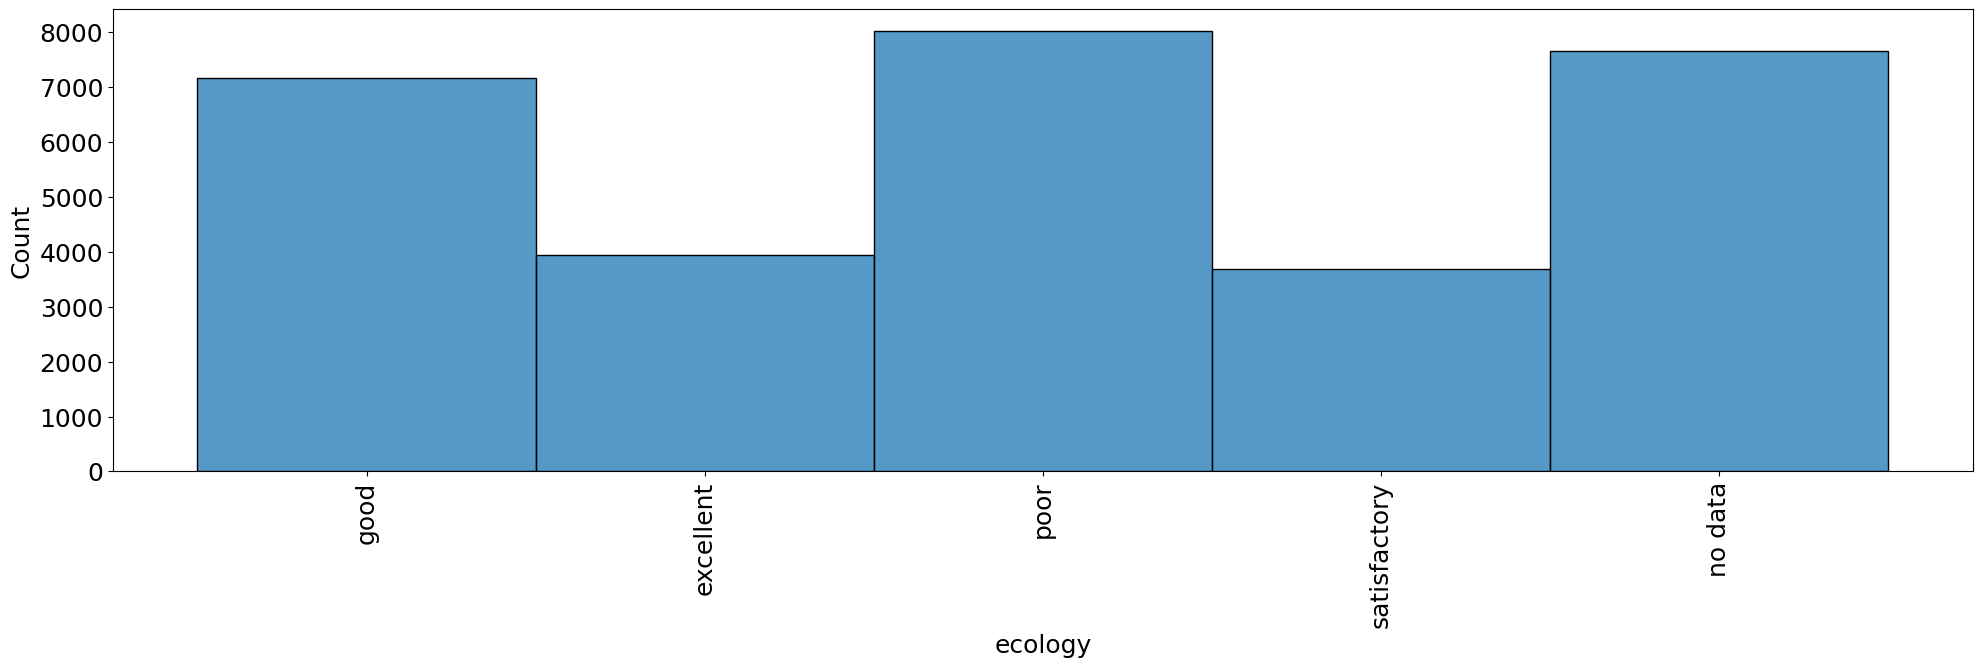

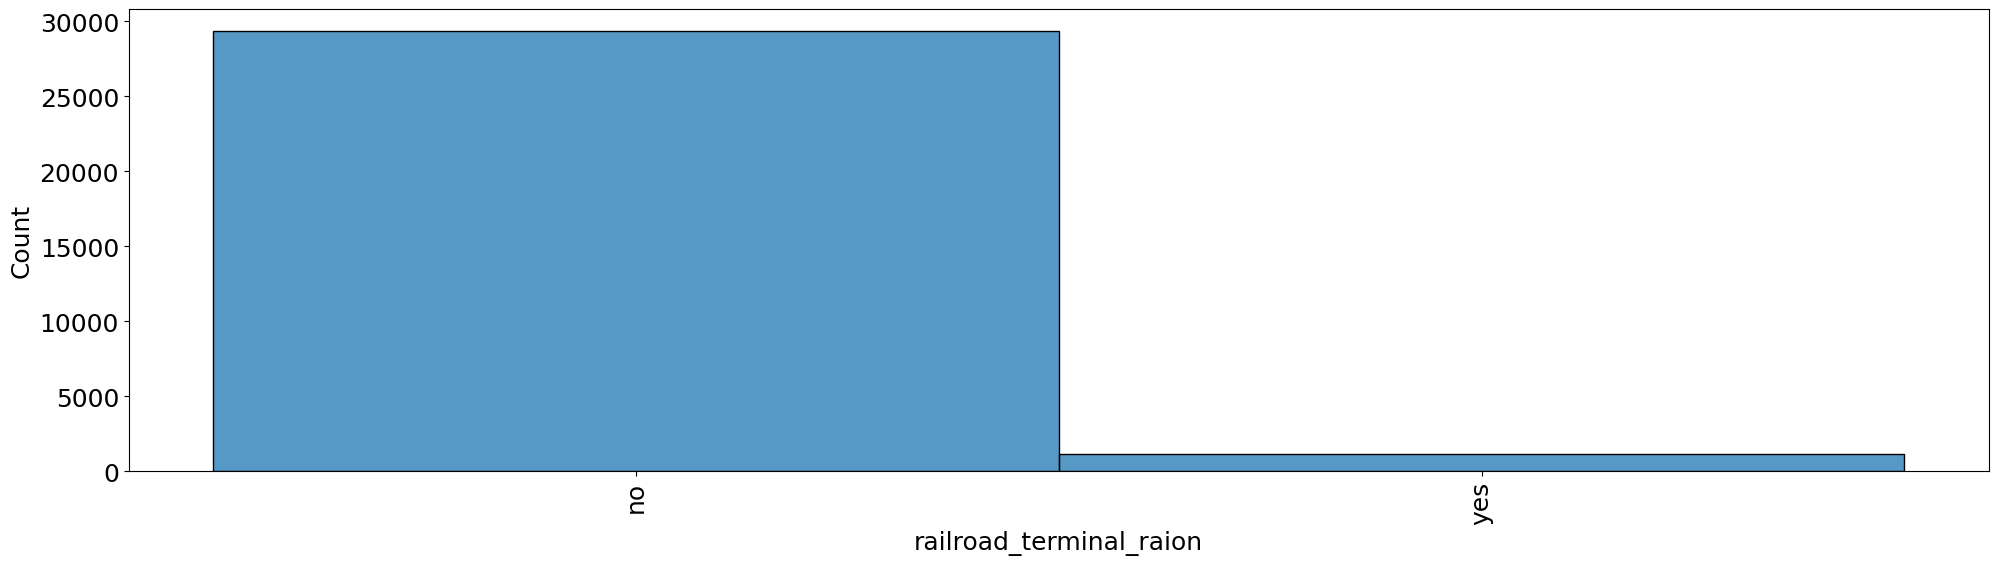

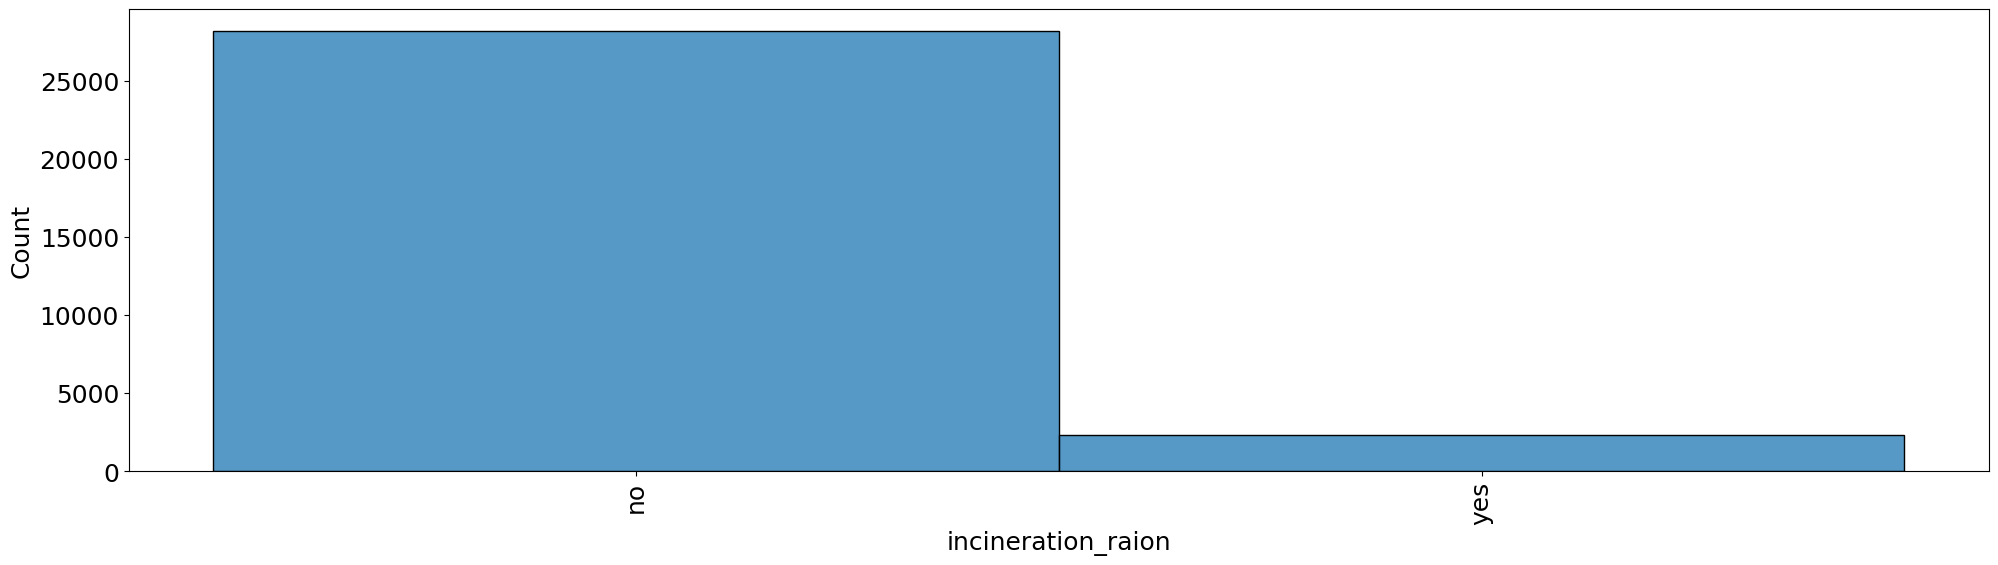

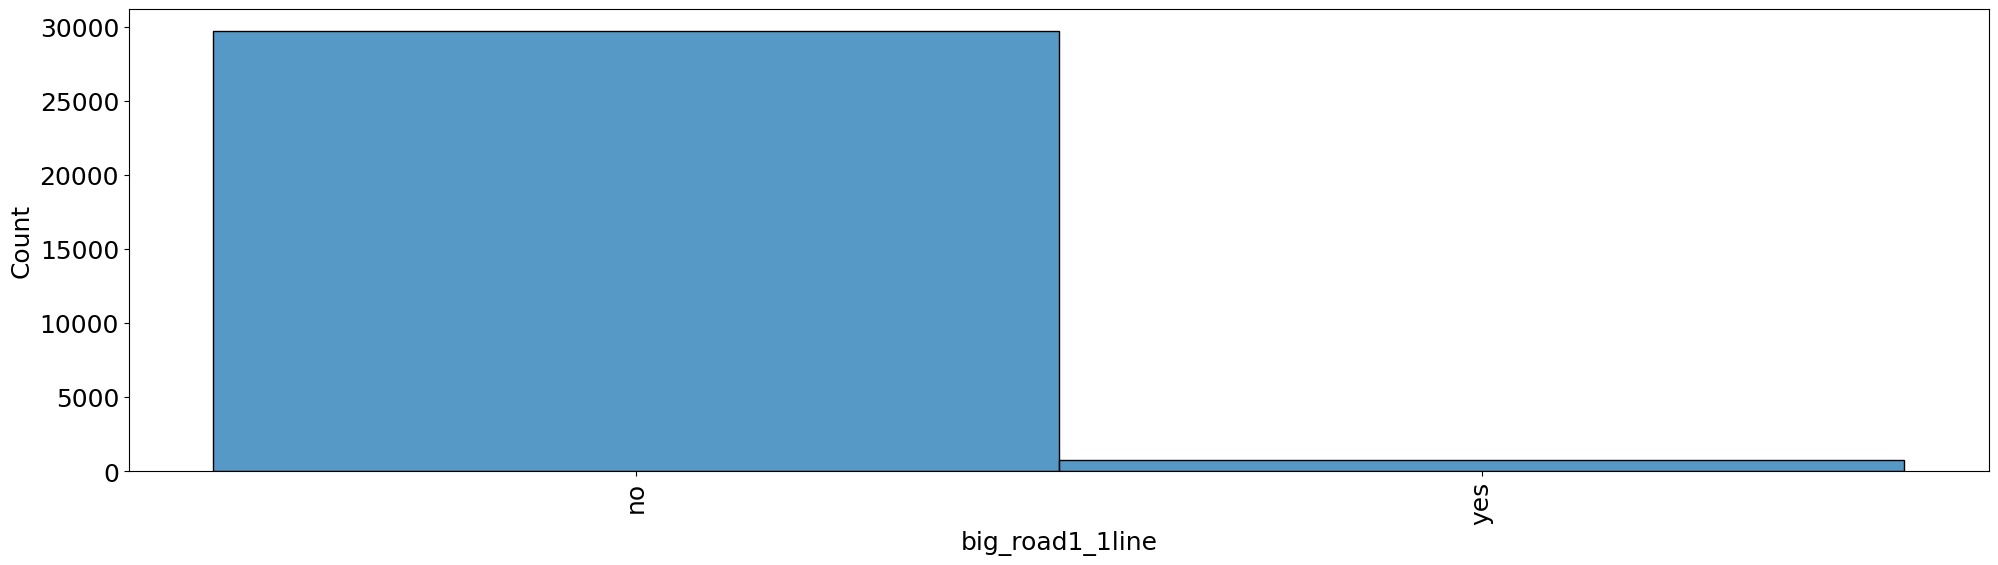

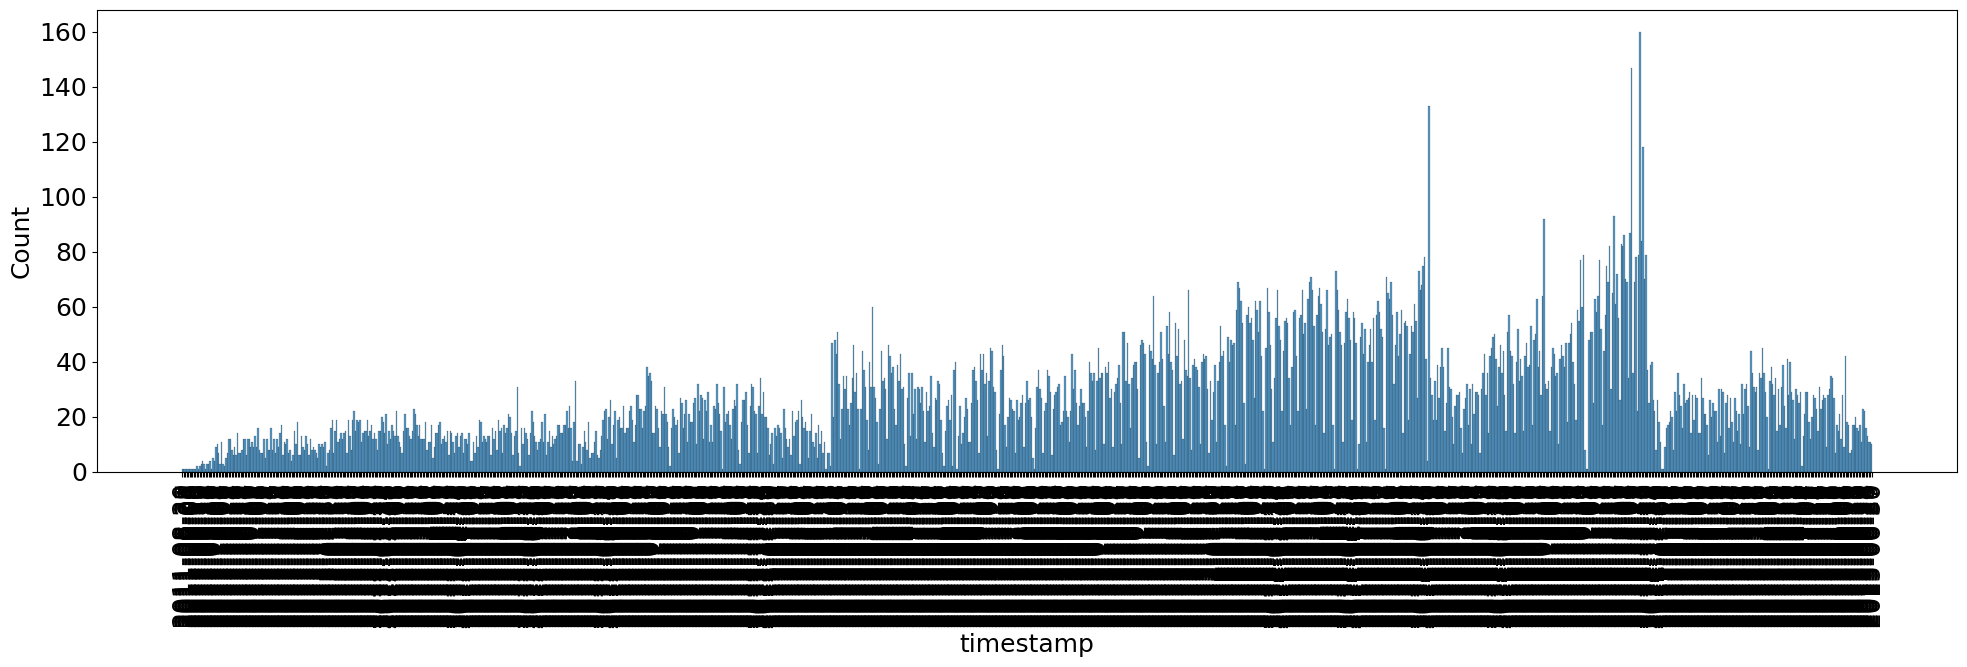

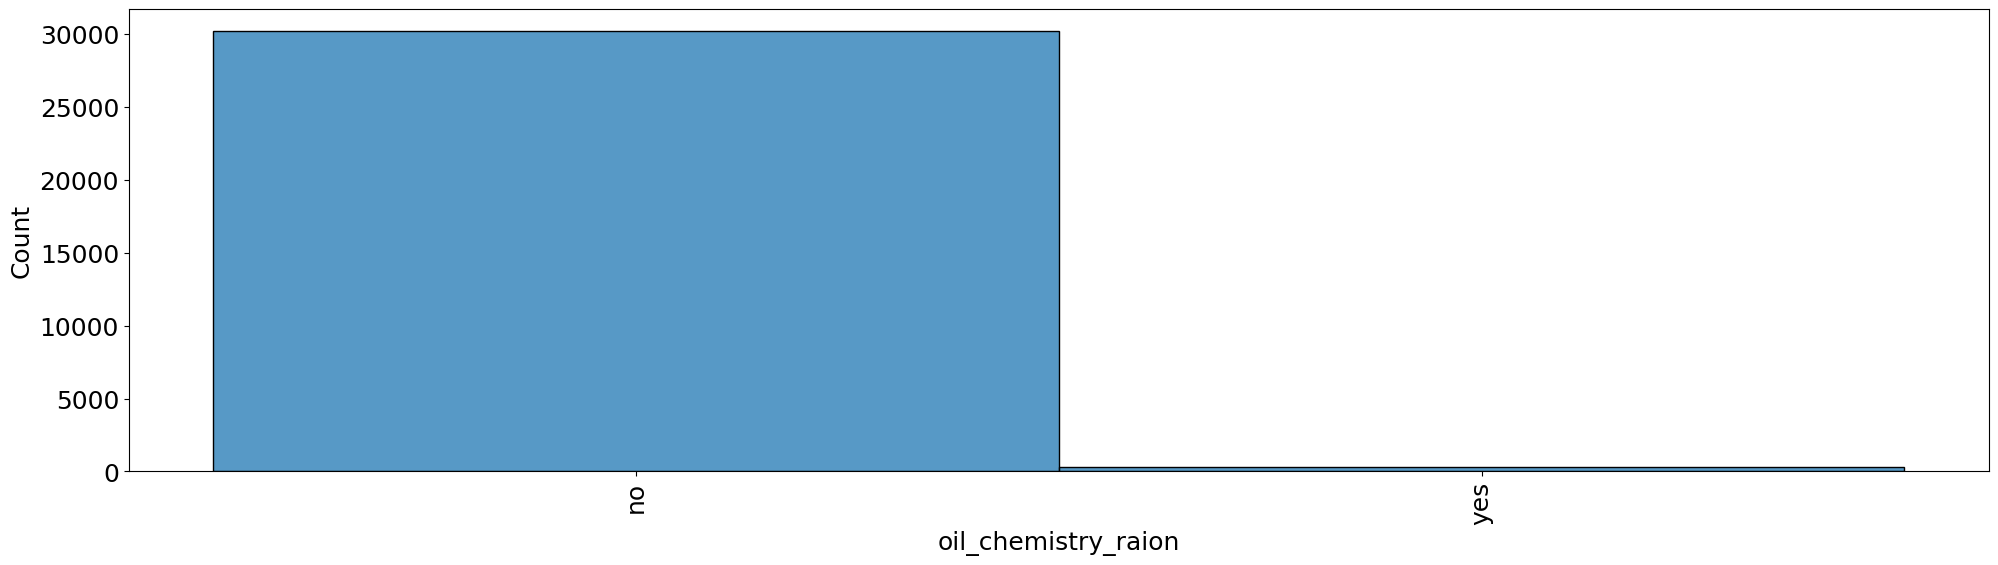

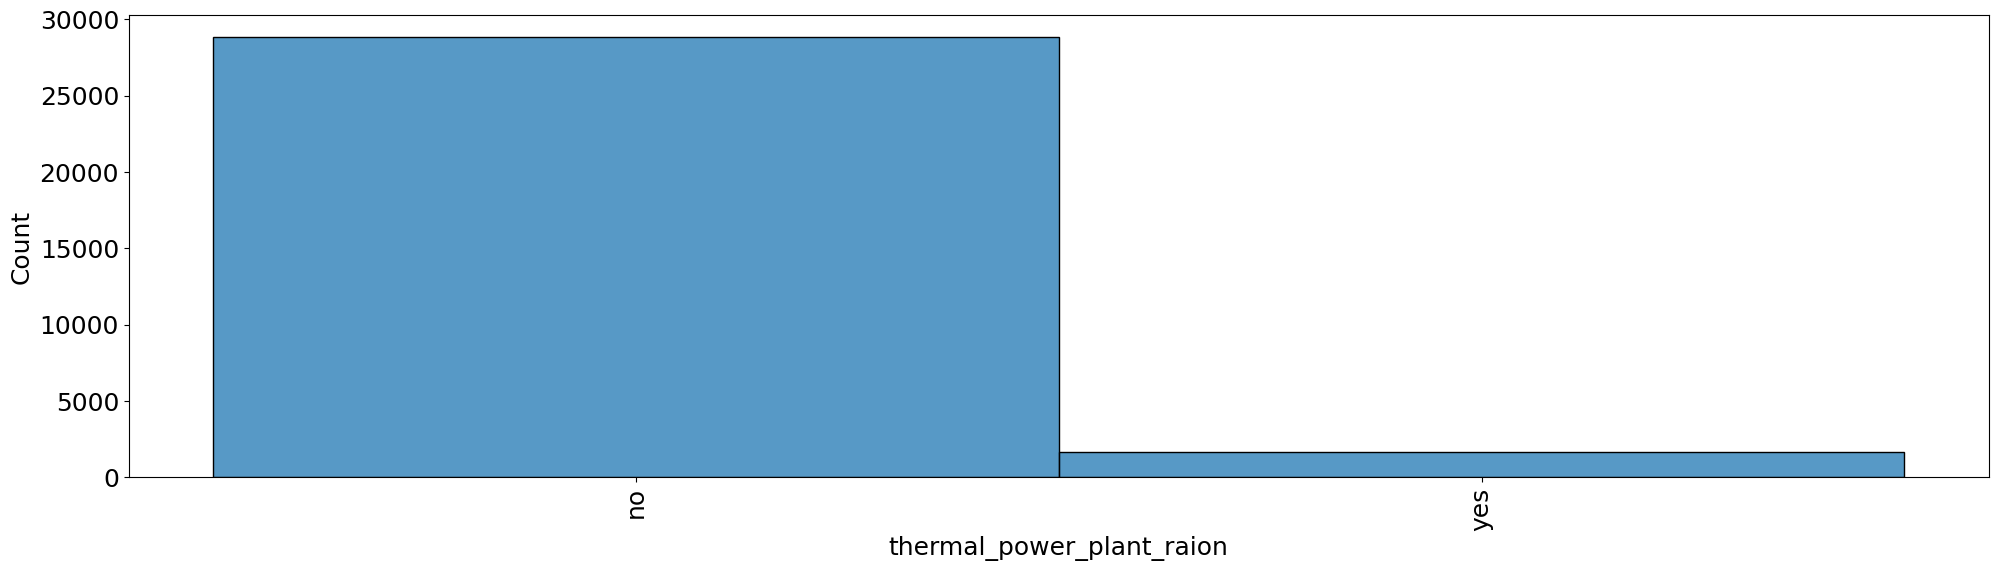

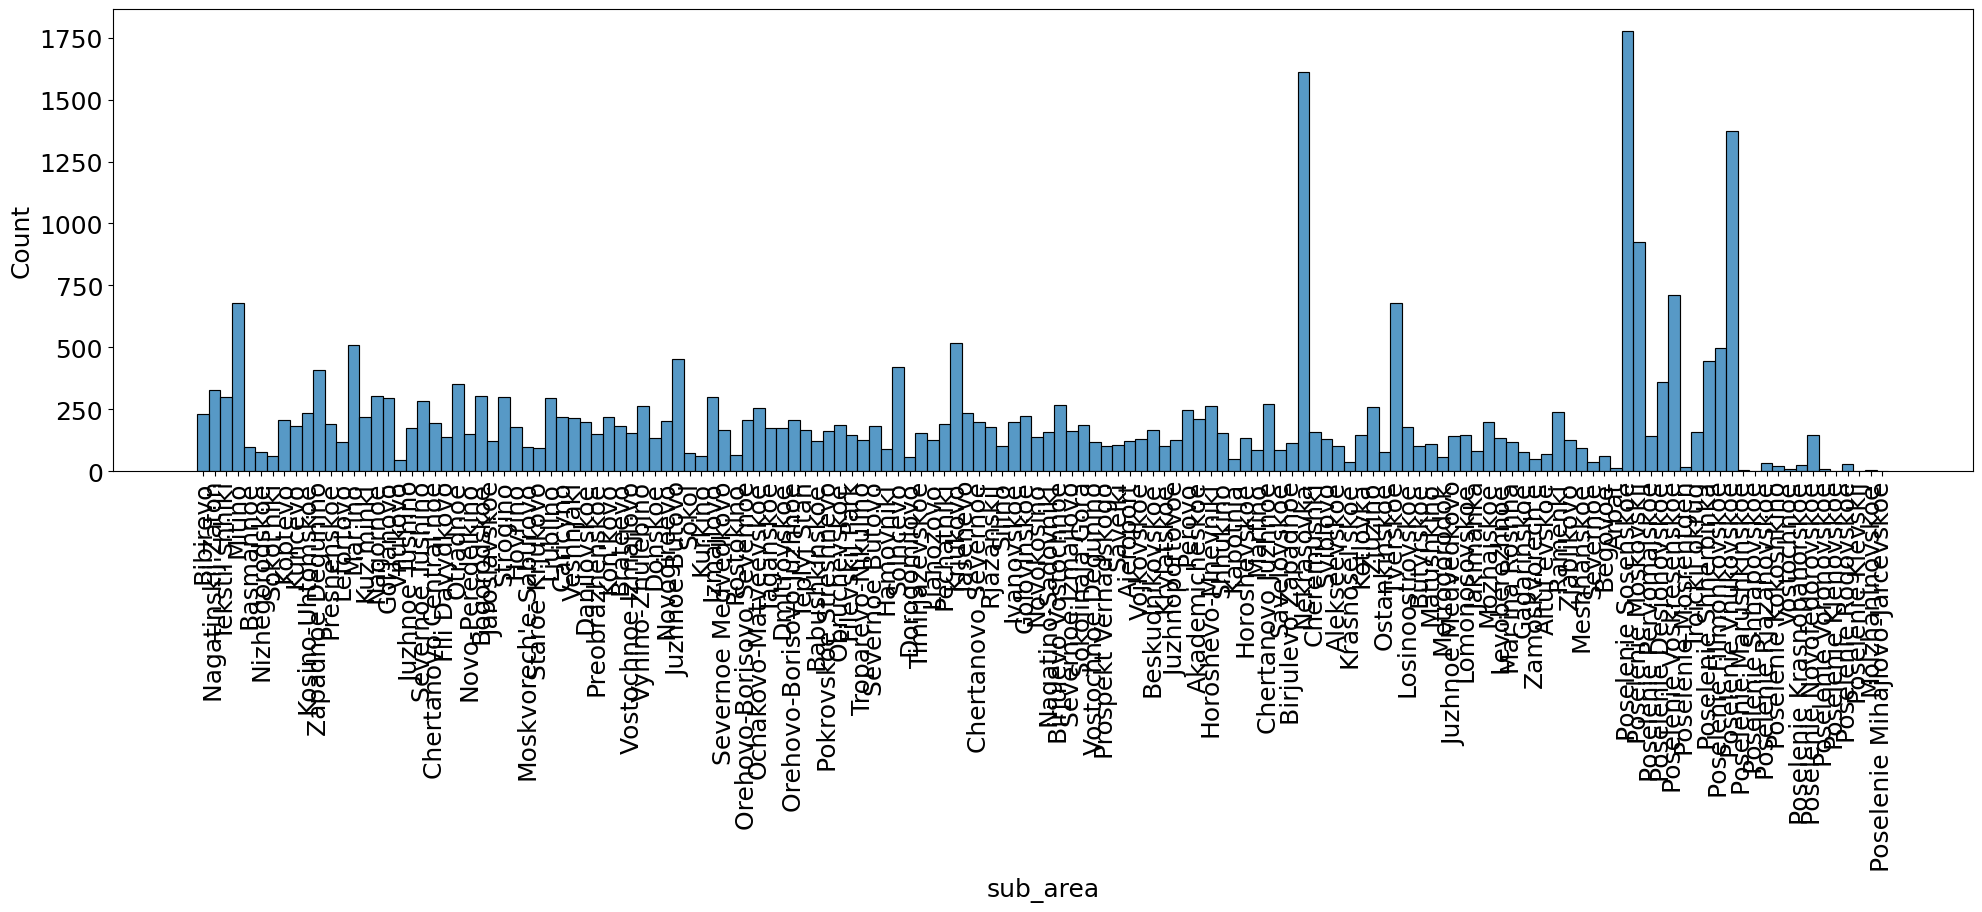

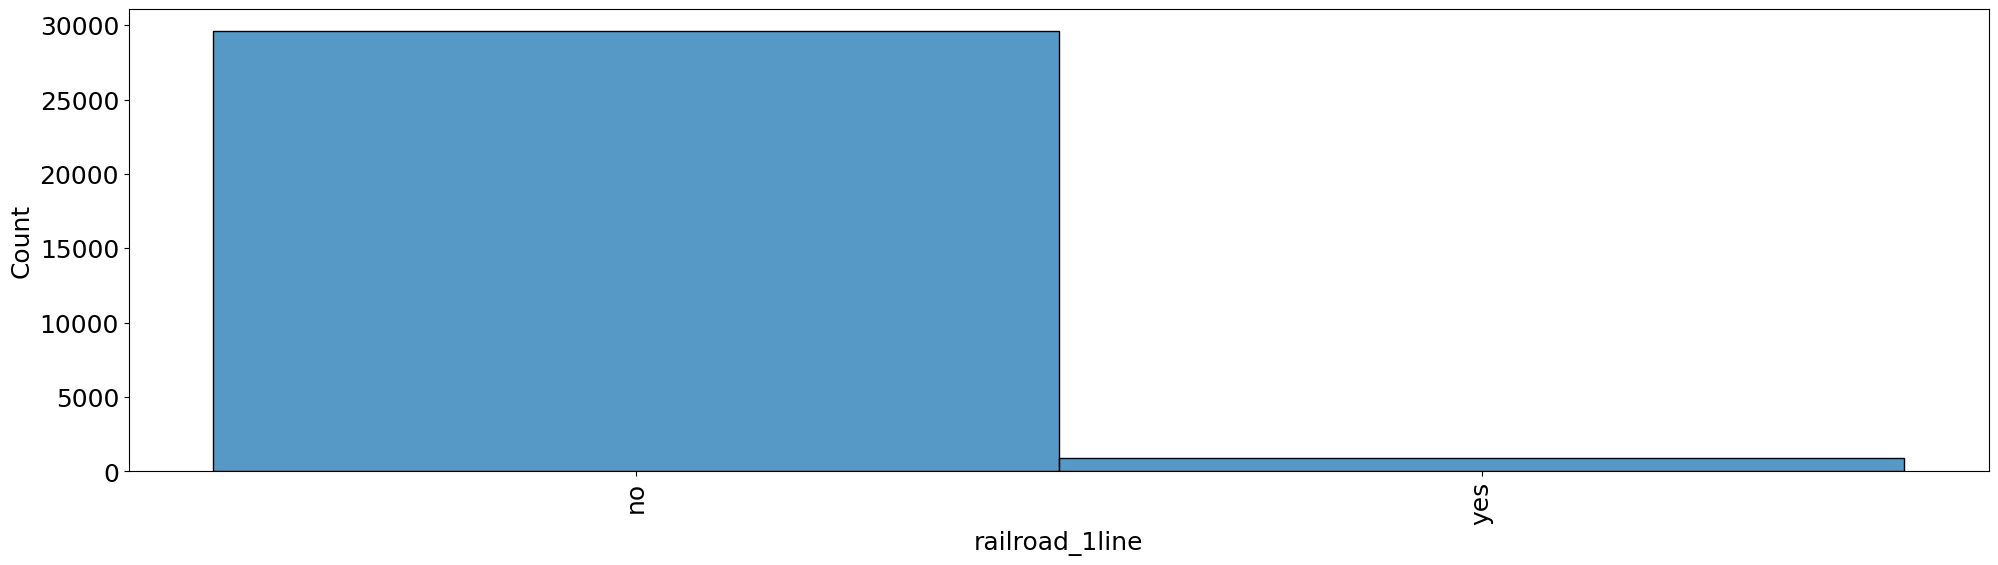

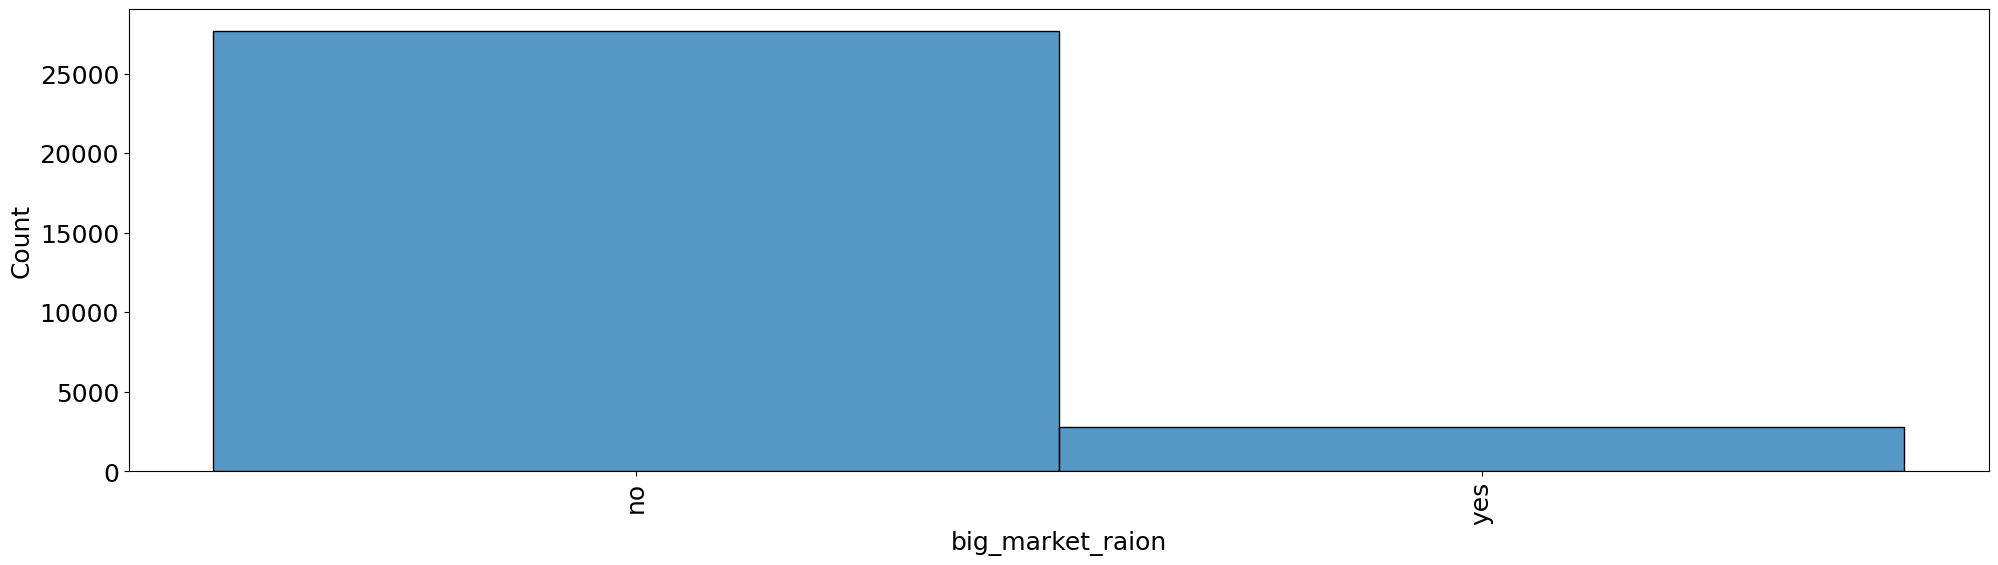

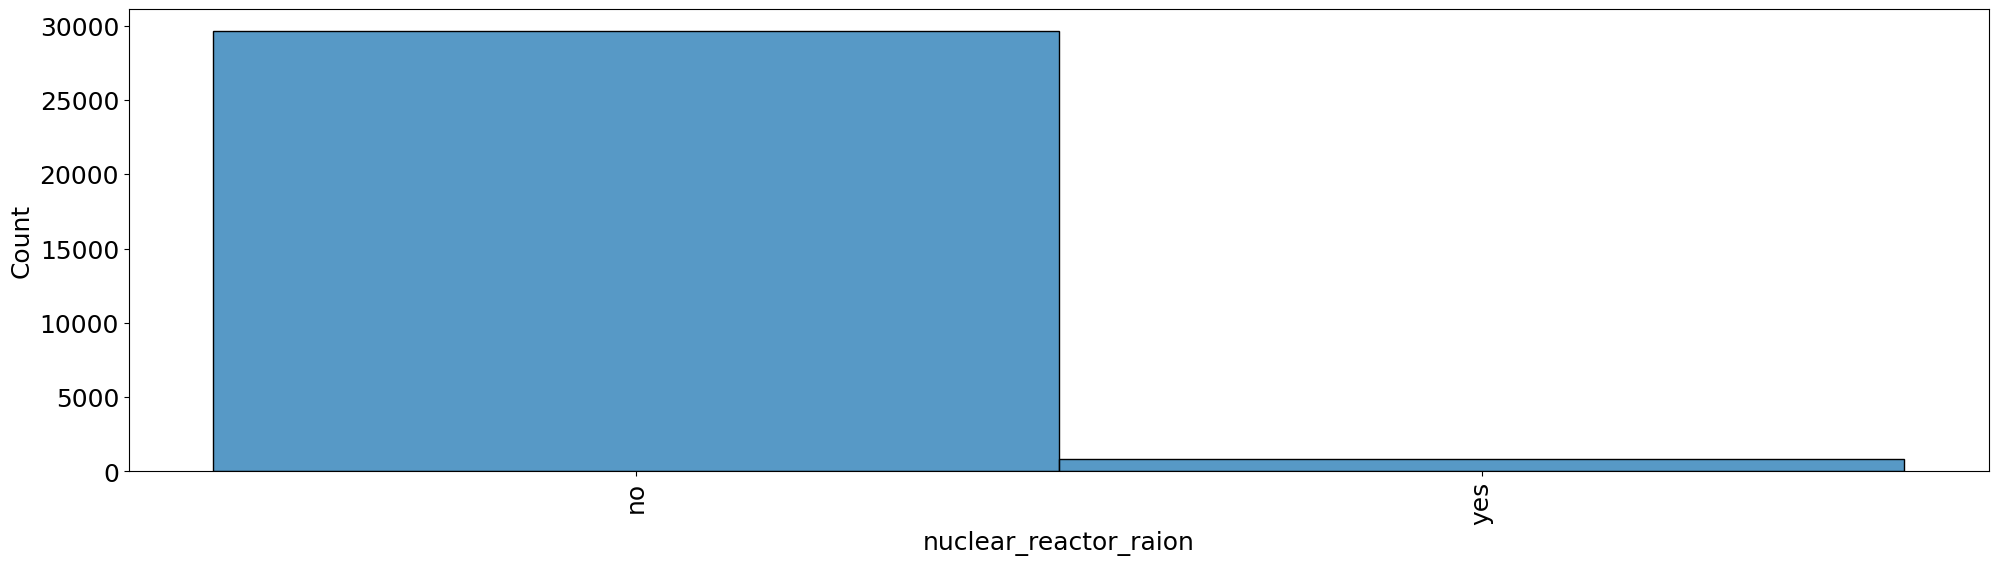

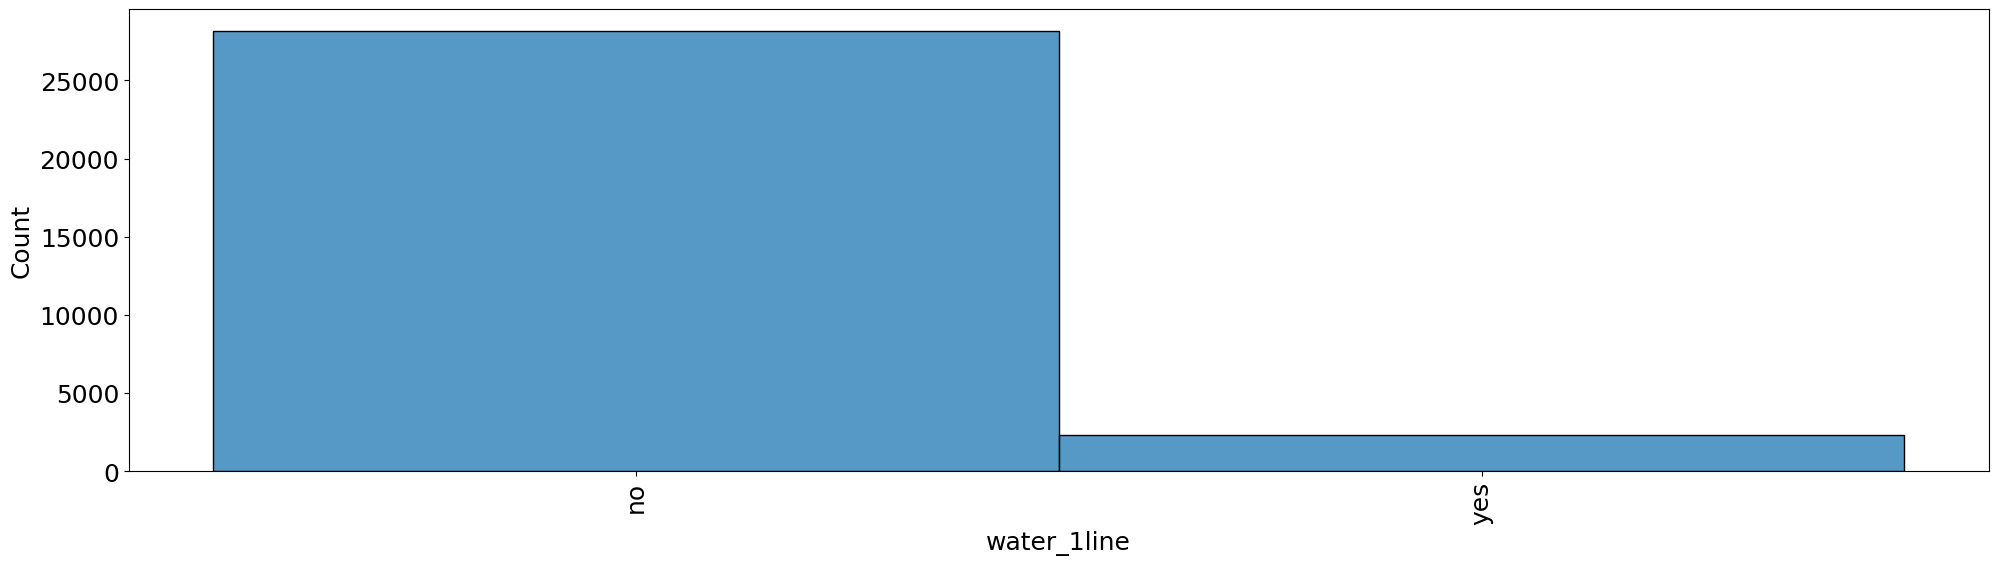

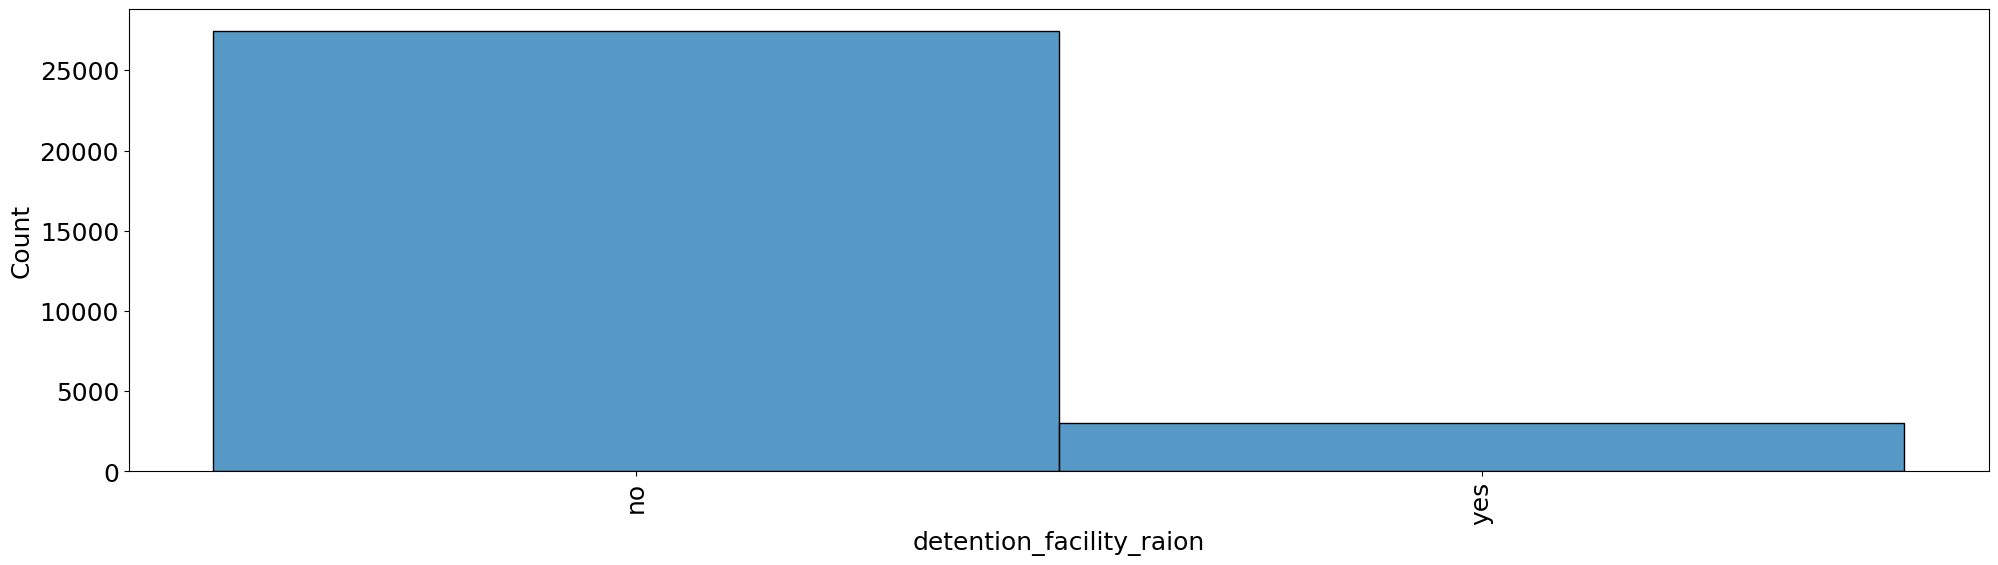

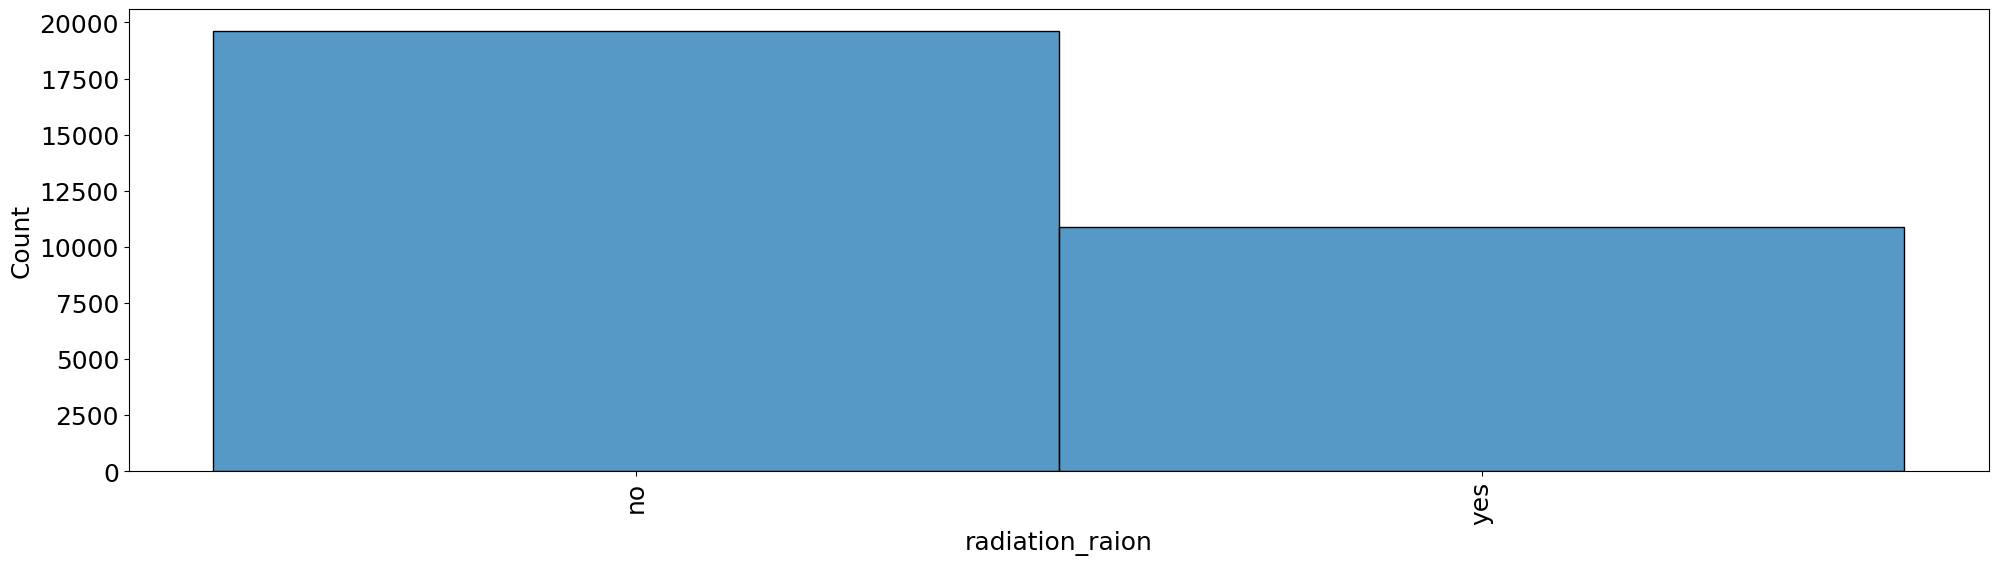

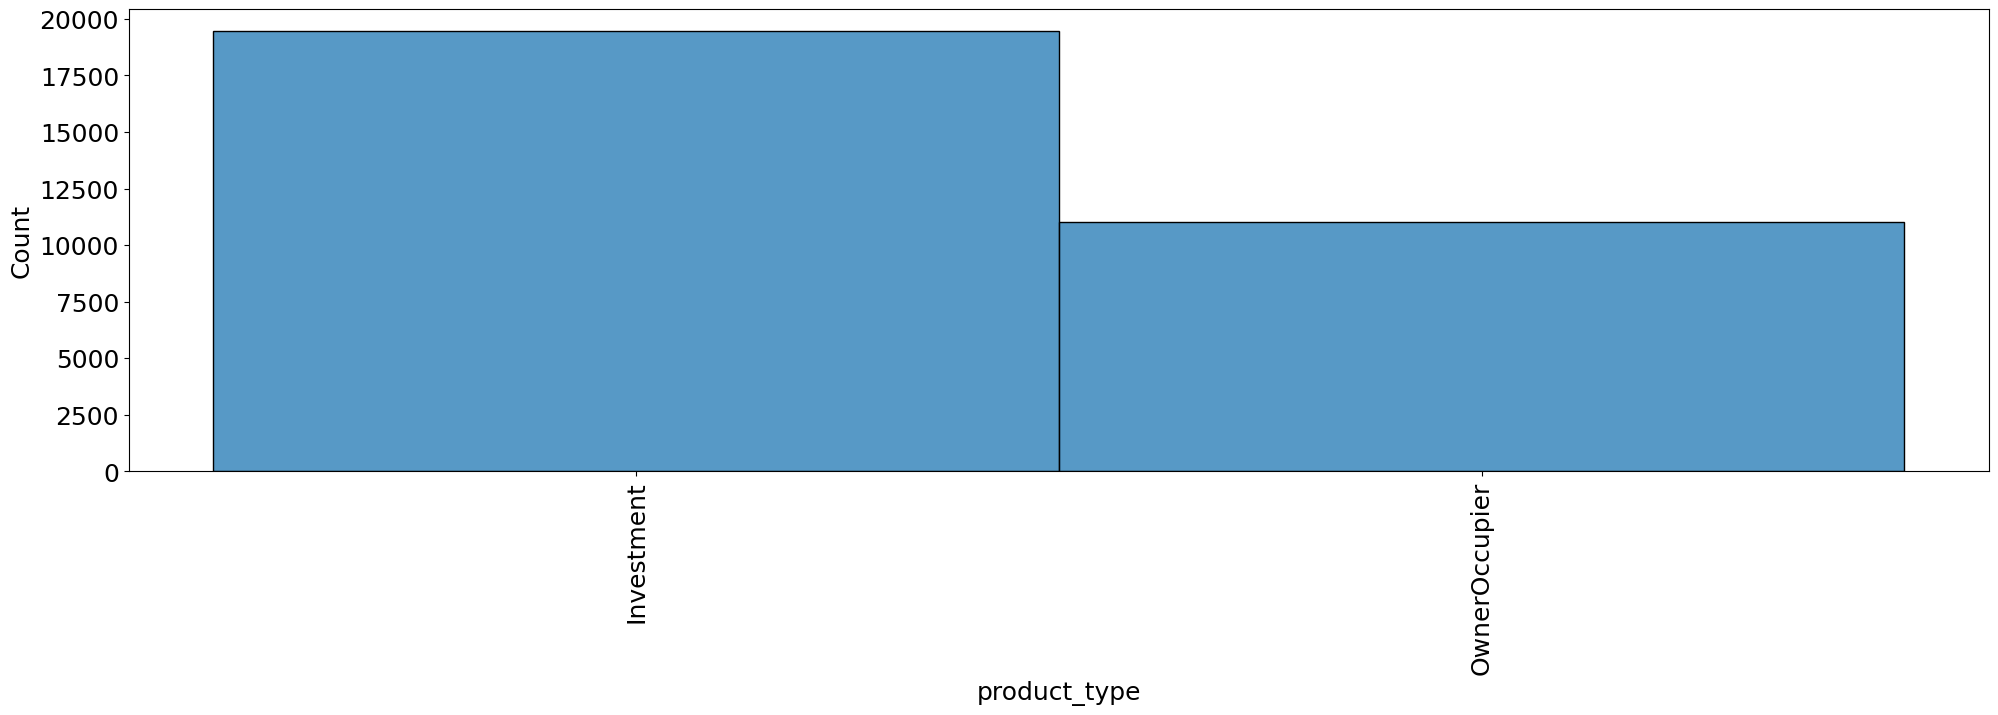

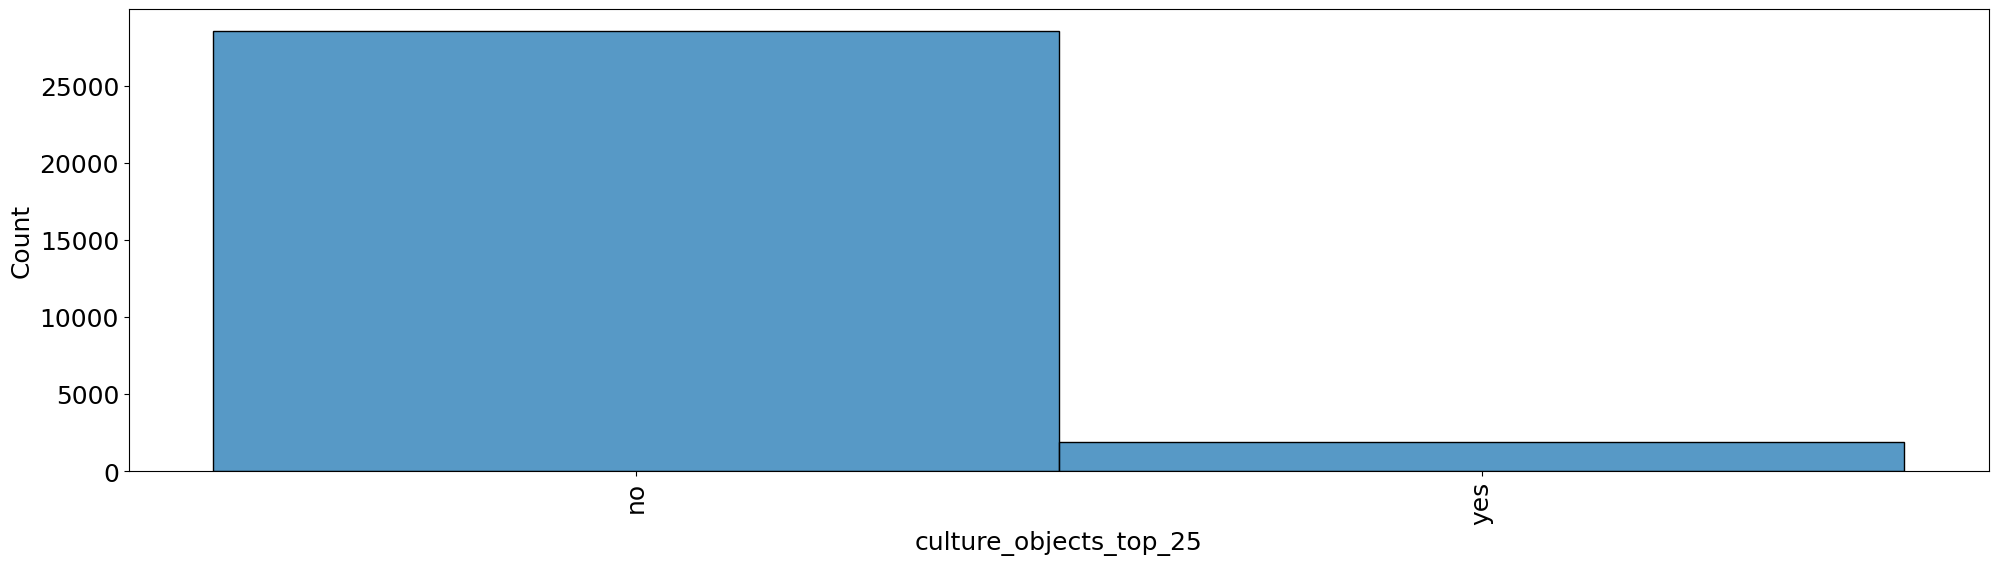

In [34]:
# Визуализация уникальных значений категориальных колонок

for col in categorical_cols:
    plt.figure(figsize=(24, 6))
    sns.histplot(data=df[categorical_cols], x=col)
    plt.xticks(rotation=90)
    plt.show()

In [35]:
# Удаляем бинарные признаки, которые встречаются резже

binary_cols = [col for col in categorical_cols if df[col].nunique() == 2 and col != "product_type"]
# "product_type" принимает значения, отличные от 'no'/'yes' и соотношение категорий приемлимое, поэтому мы сразу не будем включать сюда данный признак
categorical_cols = [col for col in categorical_cols if col not in binary_cols]
len(binary_cols), len(categorical_cols)

(12, 4)

In [36]:
min_p_yes = 0.2
for col in binary_cols:
    fr = df[col].value_counts().to_dict()
    print(col, fr)
    if fr["yes"] / fr["no"] < min_p_yes * fr["no"]:
        cols_to_delete.append(col)
len(cols_to_delete)

railroad_terminal_raion {'no': 29335, 'yes': 1136}
incineration_raion {'no': 28155, 'yes': 2316}
big_road1_1line {'no': 29690, 'yes': 781}
oil_chemistry_raion {'no': 30175, 'yes': 296}
thermal_power_plant_raion {'no': 28817, 'yes': 1654}
railroad_1line {'no': 29578, 'yes': 893}
big_market_raion {'no': 27649, 'yes': 2822}
nuclear_reactor_raion {'no': 29608, 'yes': 863}
water_1line {'no': 28134, 'yes': 2337}
detention_facility_raion {'no': 27427, 'yes': 3044}
radiation_raion {'no': 19600, 'yes': 10871}
culture_objects_top_25 {'no': 28543, 'yes': 1928}


29

In [37]:
len(set(binary_cols) & set(cols_to_delete)) == len(binary_cols)

True

In [38]:
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d")

# Проверим, что они отсортированы по возрастанию даты
(df["timestamp"] == sorted(df["timestamp"])).sum() == df.shape[0]

True

In [39]:
# Удаляем колонку с датами

last_date = df["timestamp"][:int(df.shape[0] * 0.7)].iloc[-1]
cols_to_delete.append("timestamp")
categorical_cols.remove("timestamp")

In [40]:
train_idx = df["timestamp"] <= last_date
train_idx

0         True
1         True
2         True
3         True
4         True
         ...  
30466    False
30467    False
30468    False
30469    False
30470    False
Name: timestamp, Length: 30471, dtype: bool

In [41]:
X_train = df[train_idx]
y_train = target[train_idx]

X_test = df[~train_idx]
y_test = target[~train_idx]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21332, 291), (21332,), (9139, 291), (9139,))

In [42]:
# Удаляем колонки и кодируем категориальные признаки

X_train = X_train.drop(cols_to_delete, axis=1)
X_test = X_test.drop(cols_to_delete, axis=1)

In [43]:
o_enc = OrdinalEncoder()

X_train[categorical_cols] = pd.DataFrame(
    o_enc.fit_transform(X_train[categorical_cols]),
    columns=categorical_cols
)
X_test[categorical_cols] = pd.DataFrame(
    o_enc.transform(X_test[categorical_cols]),
    columns=categorical_cols
)

In [44]:
# Проверяем, что в выборках нет пропущенных значений

nan_cols_train = (X_train.isna().sum().index[X_train.isna().sum() > 0]).tolist()
nan_cols_test = (X_test.isna().sum().index[X_test.isna().sum() > 0]).tolist()
len(nan_cols_train), len(nan_cols_test), len(set(nan_cols_train) & set(nan_cols_test))

(35, 37, 34)

In [45]:
set(nan_cols_train) & set(categorical_cols), set(nan_cols_test) & set(categorical_cols)

(set(), {'ecology', 'product_type', 'sub_area'})

In [46]:
# Проверяем, что пропусков не осталось

nan_cols_train = (X_train.isna().sum().index[X_train.isna().sum() > 0]).tolist()
nan_cols_test = (X_test.isna().sum().index[X_test.isna().sum() > 0]).tolist()
len(nan_cols_train), len(nan_cols_test)

(35, 37)

In [47]:
for col in nan_cols_train:
    X_train[col] = X_train[col].fillna(np.nanmean(X_train[col]))
    X_test[col] = X_test[col].fillna(np.nanmean(X_train[col]))

In [48]:
for col in set(nan_cols_test) & set(categorical_cols):
    fill_with = X_train[col].value_counts().index[0]
    X_test[col] = X_test[col].fillna(fill_with)

In [49]:
# Подбор гиперпараметров

CONFIG_DATA = {
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}
CONFIG_REG = {
    "scoring": "r2", # подбирать гиперпараметры будем по R2
    "model_type": "regression",
}

In [50]:
ans_cl = dict()
print("Результаты моделей с гиперпараметрами по умолчанию\n")
for model_name, model in tqdm(
        zip(
            ["RandomForest", "XGBoost", "LightGBM", "CatBoost"],
            [RandomForestRegressor(), XGBRegressor(), LGBMRegressor(), CatBoostRegressor(verbose=0)]
        )
):
    print(model_name)
    preds, metrics = model_train_test(model=model, model_type="regression", **CONFIG_DATA)
    ans_cl[model_name] = (preds, metrics)
    print("-"*100)

Результаты моделей с гиперпараметрами по умолчанию



0it [00:00, ?it/s]

RandomForest


1it [05:59, 359.53s/it]

MSE = 9501679400110.586; MAE = 1871724.967; R2 = 0.657
----------------------------------------------------------------------------------------------------
XGBoost


2it [06:10, 154.24s/it]

MSE = 9137418104574.637; MAE = 1826448.864; R2 = 0.67
----------------------------------------------------------------------------------------------------
LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38744
[LightGBM] [Info] Number of data points in the train set: 21332, number of used features: 261
[LightGBM] [Info] Start training from score 6825437.465123


3it [06:16, 86.63s/it] 

MSE = 8679142746560.804; MAE = 1795975.723; R2 = 0.686
----------------------------------------------------------------------------------------------------
CatBoost


4it [07:23, 110.92s/it]

MSE = 8394659973743.697; MAE = 1789780.508; R2 = 0.697
----------------------------------------------------------------------------------------------------


In [51]:
ans_cl_df = pd.DataFrame(ans_cl).T
ans_cl_df["MSE"] = ans_cl_df[1].apply(lambda x: x[0])
ans_cl_df["MAE"] = ans_cl_df[1].apply(lambda x: x[1])
ans_cl_df["R2"] = ans_cl_df[1].apply(lambda x: x[2])
ans_cl_df = ans_cl_df.drop([0, 1], axis=1)

# Отсортируем получившуюся таблицу по убыванию R2
ans_cl_df.sort_values("R2", ascending=False)

,MSE,MAE,R2
CatBoost,8.394660e+12,1.789781e+06,0.696709
LightGBM,8.679143e+12,1.795976e+06,0.686431
XGBoost,9.137418e+12,1.826449e+06,0.669874
RandomForest,9.501679e+12,1.871725e+06,0.656713
